In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns

from IPython.lib.pretty import pretty

import geopandas as gpd
import contextily as ctx
from geopy.distance import great_circle

from shapely.geometry import Point

import matplotlib.pyplot as plt
plt.style.use('seaborn')
from mpl_toolkits.basemap import Basemap

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import lasso_path
import xgboost
import shap

## DUBLIN

#### Loading  dataset

In [2]:
data = pd.read_csv('listings_dublin.csv')


print(f'Dataset contains {data.shape[0]} rows and {data.shape[1]} columns')
print(f'Dataset number of duplicates in the dataset {data.duplicated().sum()}')
print()
print(data.columns)

Dataset contains 6976 rows and 74 columns
Dataset number of duplicates in the dataset 0

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_

### Selection of the relevant and useful information

In [3]:
selected_columns = ['id', 'host_is_superhost', 'host_identity_verified','neighbourhood_cleansed', 'latitude','longitude', 'room_type', 'accommodates','bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'instant_bookable']

#### Dropping redudant columns and crate a new dataset.

In [4]:
# getting new dataframe
dataset = data[selected_columns].set_index('id')
print(f'Dataset contains {dataset.shape[0]} rows and {dataset.shape[1]} columns')

Dataset contains 6976 rows and 13 columns


Brief check of the dataset

In [5]:
# initializing new data frame that will be displayed in the table
data_review = pd.DataFrame(columns = ['Column','Data Type','Misssing Values', '[%] Missing Values', 'Sum Unique Val'])

# looping via columns and extracting needed information
for index, column in enumerate(dataset.columns):
    data_type = dataset.dtypes[column]
    missing_value = dataset[column].isnull().sum()
    percentage = round((missing_value/len(dataset))* 100,1) if (missing_value/len(dataset))* 100 else 0
    unique_val = len(dataset[column].unique())
    data_review.loc[index] = [column, data_type, missing_value,percentage,unique_val]
    
data_review.head(len(data_review)) # show table

,Column,Data Type,Misssing Values,[%] Missing Values,Sum Unique Val
0,host_is_superhost,object,11,0.2,3
1,host_identity_verified,object,11,0.2,3
2,neighbourhood_cleansed,object,0,0.0,4
3,latitude,float64,0,0.0,4891
4,longitude,float64,0,0.0,5363
5,room_type,object,0,0.0,4
6,accommodates,int64,0,0.0,16
7,bathrooms_text,object,6,0.1,30
8,bedrooms,float64,236,3.4,10
9,beds,float64,242,3.5,16


## Initial data analysis and preparation



#### Host is superhost

We convert it t and f vales to boolean True and False

In [6]:
dataset.replace({'host_is_superhost' : {'t' : True, 'f' : False}}, inplace=True)
print( dataset['host_is_superhost'].head(2) )

id
44077     True
85148    False
Name: host_is_superhost, dtype: object


We assume that the null values represent 'normal' hosts

In [7]:
dataset['host_is_superhost'].fillna(False, inplace=True)

#### Price

Convering the price columns to float type

In [8]:
dataset['price'] = dataset['price'].apply(lambda x: x.replace("$", ""))
dataset['price'] = dataset['price'].apply(lambda x: x.replace(",", ""))


In [9]:
 pd.options.display.float_format = "{:.2f}".format
# to fix the issue with .describe() method
# https://stackoverflow.com/questions/41328633/how-do-i-print-entire-number-in-python-from-describe-function

In [10]:
dataset.price = pd.to_numeric(dataset.price, errors='coerce')

In [11]:
dataset['price'].describe()

count      6976.00
mean        303.54
std       14053.32
min           9.00
25%          55.00
50%          85.00
75%         150.00
max     1173721.00
Name: price, dtype: float64

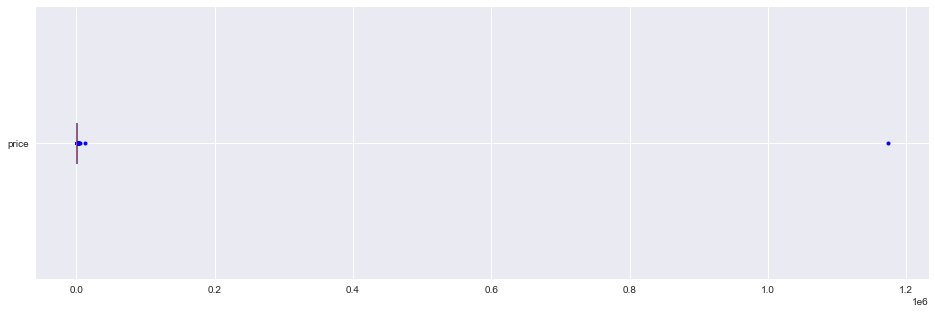

In [12]:
box = dict(markerfacecolor='b', markeredgecolor='b', marker='.')
dataset['price'].plot(kind='box', vert=False, flierprops=box, figsize=(16,5))

#### Removing max values

In [13]:
maximum = dataset['price'].describe()[7]

In [14]:
dataset = dataset[(dataset.price < maximum)]

In [15]:
dataset['price'].describe()

count    6975.00
mean      135.31
std       247.56
min         9.00
25%        55.00
50%        85.00
75%       150.00
max     12100.00
Name: price, dtype: float64

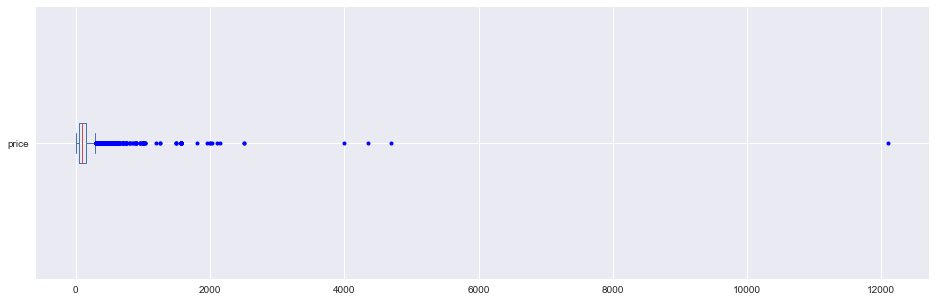

In [16]:
dataset['price'].plot(kind='box', vert=False, flierprops=box, figsize=(16,5))

#### Removing outliers

In [17]:
dataset = dataset[(dataset.price <= np.percentile(dataset.price, 99.5)) & (dataset.price > 0)]

In [18]:
dataset['price'].describe()

count   6962.00
mean     129.22
std      167.24
min        9.00
25%       55.00
50%       85.00
75%      150.00
max     1570.00
Name: price, dtype: float64

#### Removing more outliers

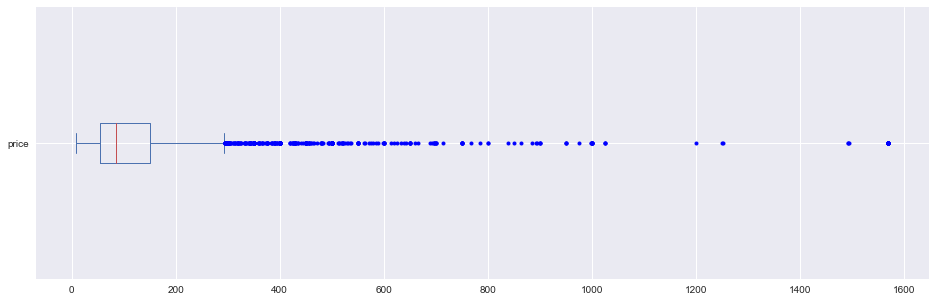

In [19]:
dataset['price'].plot(kind='box', vert=False, flierprops=box, figsize=(16,5))

In [20]:
# #Getting Fraction of values within three SD
std = dataset['price'].describe()[2]
mean = dataset['price'].describe()[1]
threeSD = int(3 * std)

In [21]:
print(threeSD)

501


In [22]:
over_800 = dataset[(dataset.price > 800)]

In [23]:
dataset = dataset[(dataset.price <= 800)]

In [24]:
print(f"We consider all Airbnbs of price over 800 euro as outliers. Those are only {  round((over_800.shape[0]/dataset.shape[0])*100, 2) }% of all places")

We consider all Airbnbs of price over 800 euro as outliers. Those are only 1.15% of all places


#### Instant bookable
Converting values to True and False

In [25]:
print( dataset['instant_bookable'].head(2), '\n')
print('Number of places where we have NULL values', dataset['instant_bookable'].isnull().sum(), '\n')
print( dataset["instant_bookable"].value_counts().sort_index(), '\n' )

id
44077    f
85148    f
Name: instant_bookable, dtype: object 

Number of places where we have NULL values 0 

f    4590
t    2293
Name: instant_bookable, dtype: int64 



In [26]:
dataset.replace({'instant_bookable' : {'t' : True, 'f' : False}}, inplace=True)
print( dataset['instant_bookable'].head(2) )

id
44077    False
85148    False
Name: instant_bookable, dtype: bool


#### Host identity verified
Converting values to True and False and setting null values as False

In [27]:
print( dataset['host_identity_verified'].head(2), '\n')
print('Number of places where we have NULL values', dataset['host_identity_verified'].isnull().sum(), '\n')
print( dataset["host_identity_verified"].value_counts().sort_index(), '\n' )

id
44077    t
85148    f
Name: host_identity_verified, dtype: object 

Number of places where we have NULL values 11 

f    1994
t    4878
Name: host_identity_verified, dtype: int64 



In [28]:
dataset.replace({'host_identity_verified' : {'t' : True, 'f' : False}}, inplace=True)
print( dataset['host_identity_verified'].head(2) )

id
44077     True
85148    False
Name: host_identity_verified, dtype: object


In [29]:
dataset['host_identity_verified'].fillna(False, inplace=True)

#### Bedrooms

In [30]:
print( dataset['bedrooms'].head(2), '\n')
print('Number of places where we have NULL values', dataset['bedrooms'].isnull().sum(), '\n')
print( dataset["bedrooms"].value_counts().sort_index(), '\n' )

id
44077   1.00
85148   1.00
Name: bedrooms, dtype: float64 

Number of places where we have NULL values 232 

1.00    4559
2.00    1292
3.00     479
4.00     256
5.00      51
6.00      11
7.00       2
9.00       1
Name: bedrooms, dtype: int64 



We drop null rows with null values in the bedrooms column

In [31]:
dataset = dataset[pd.notnull(dataset['bedrooms'])]

#### Beds

We drop null rows with null values in the beds column

In [32]:
dataset = dataset[pd.notnull(dataset['beds'])]

In [33]:
print('Number of places where we have NULL values', dataset['beds'].isnull().sum(), '\n')

Number of places where we have NULL values 0 



### Cleaning and processing the column with Amenities

In [34]:
dataset['amenities'].head(5)

id
44077     ["Shower gel", "Hangers", "Cleaning products",...
85148     ["Hangers", "Free parking on premises", "Dedic...
85156     ["Hangers", "Patio or balcony", "Hot water", "...
159889    ["Hangers", "Hot water", "Heating", "Fire exti...
162809    ["Hangers", "Hot water", "Cleaning products", ...
Name: amenities, dtype: object

In [35]:
from collections import Counter

results = Counter()
counted = dataset['amenities'].str.strip('[]')\
               .str.replace('"', '')\
               .str.lstrip('\"')\
                .str.lstrip()\
                .str.rstrip()\
               .str.rstrip('\"')\
               .str.split(',')\
               .apply(results.update)

#### 30 most common amenities in Dublin's dataset and their count

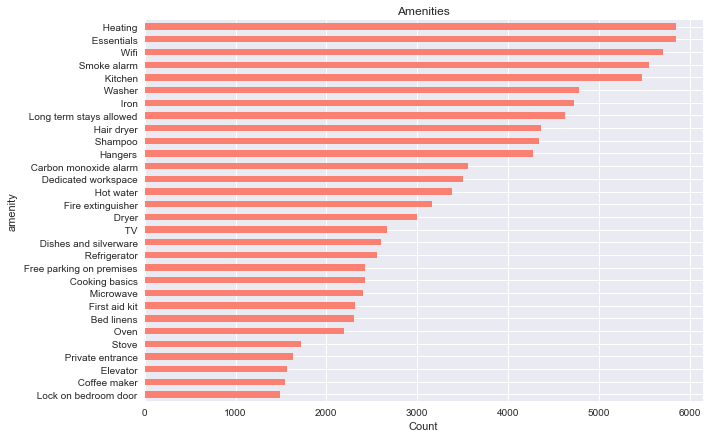

In [36]:
# create a new dataframe
sub_df = pd.DataFrame(results.most_common(30), columns=['amenity', 'count'])
# plot the Top 30
sub_df.sort_values(by=['count'], ascending=True).plot(kind='barh', x='amenity', y='count',  
                                                      figsize=(10,7), legend=False, color='salmon',
                                                      title='Amenities')
plt.xlabel('Count');

We decided that the best approach in this situation is addition of the a new column [**amenities_no**] that will store the amount of amenities per each Airbnb.

In [37]:
dataset['amenities_no'] = dataset['amenities'].str.replace('{', '').str.replace('{', '')\
               .str.replace('"', '')\
               .str.lstrip('\"')\
               .str.rstrip('\"')\
               .str.split(',').str.len()

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


In [38]:
dataset['amenities_no'].describe()

count   6433.00
mean      20.73
std       10.38
min        1.00
25%       13.00
50%       18.00
75%       27.00
max       72.00
Name: amenities_no, dtype: float64

In [39]:
dataset.drop(['amenities'], axis=1, inplace=True)

### Exploring and analyzing dataset based on the location of Airbnb in Dublin

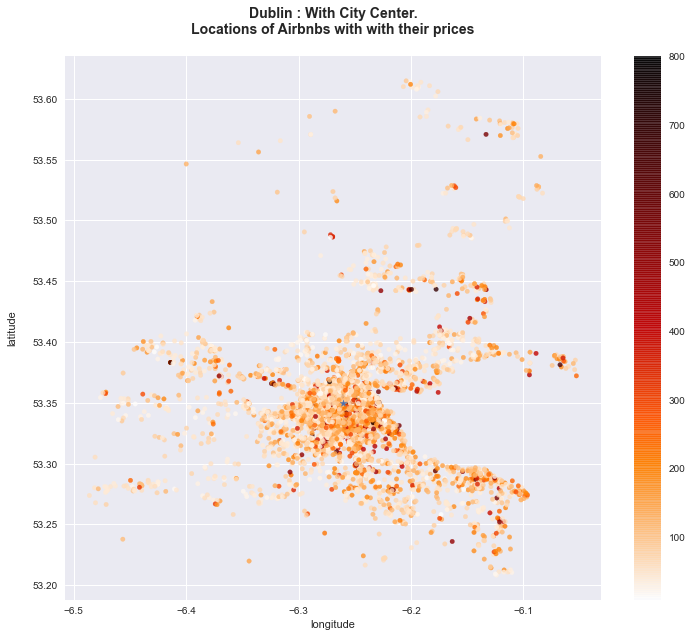

In [40]:
# using mapplotlib scatterplot 
dublin_centre = (53.349722, -6.260278) # source WIKI 53.349722, -6.260278
fig = plt.figure(figsize = (12, 10))
plt.scatter(x=dataset["longitude"], y=dataset["latitude"],c=dataset["price"], cmap='gist_heat_r',s=20,alpha=0.8)
plt.colorbar()
ploted_center = plt.scatter(dublin_centre[1], dublin_centre[0], marker='*')
plt.xlabel('longitude')
plt.ylabel('latitude\n')
plt.title('Dublin : With City Center.\nLocations of Airbnbs with with their prices\n', fontsize=14, fontweight='bold')
plt.show()

Same idea but done with geopandas & contextily


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6


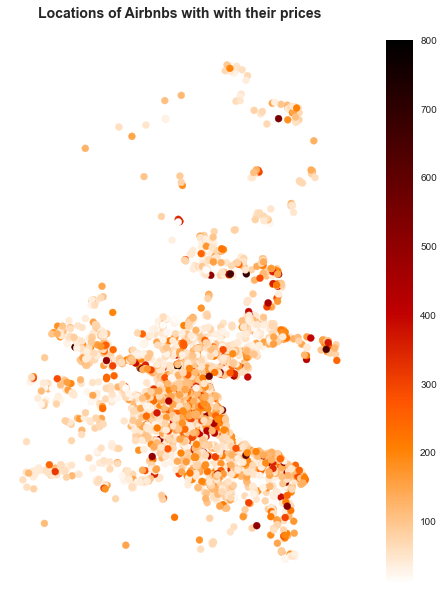

In [41]:
def add_basemap(ax, zoom):
    xmin, xmax, ymin, ymax = ax.axis()
    ax.axis((xmin, xmax, ymin, ymax))

# Let's define our raw data, whose epsg is 4326
df = dataset[["longitude","latitude","price"]]
df['coords'] = list(zip(dataset["longitude"], dataset["latitude"]))

# ... turn them into geodataframe, and convert our
# epsg into 3857, since web map tiles are typically
# provided as such.
geo_df = gpd.GeoDataFrame(
    df, crs  ={'init': 'epsg:4326'},
    geometry = df['coords'].apply(Point)
).to_crs(epsg=3857)

# ... and make the plot
ax = geo_df.plot(
    figsize= (12, 10),
    column= "price",
    cmap = "gist_heat_r",
    legend=True
)
ax.set_axis_off()
plt.title('Locations of Airbnbs with with their prices\n', fontsize=14, fontweight='bold')

plt.show()

And the same one but this time with a basemap


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6


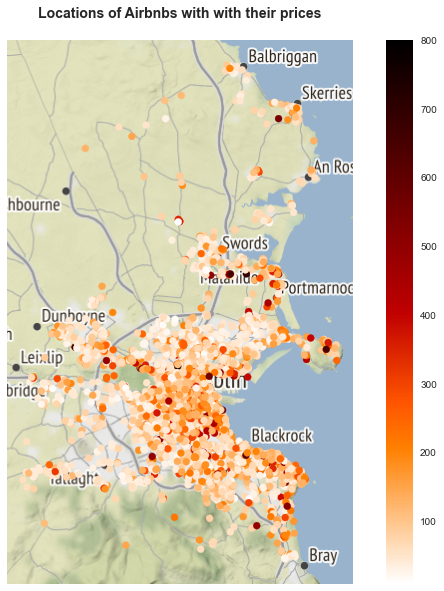

In [42]:
def add_basemap(ax, zoom):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    ax.axis((xmin, xmax, ymin, ymax))

# Let's define our raw data, whose epsg is 4326
df = dataset[["longitude","latitude","price"]]
df['coords'] = list(zip(dataset["longitude"], dataset["latitude"]))

# ... turn them into geodataframe, and convert our
# epsg into 3857, since web map tiles are typically
# provided as such.
geo_df = gpd.GeoDataFrame(
    df, crs  ={'init': 'epsg:4326'},
    geometry = df['coords'].apply(Point)
).to_crs(epsg=3857)

# ... and make the plot
ax = geo_df.plot(
    figsize= (12, 10),
    column= "price",
    cmap = "gist_heat_r",
    legend=True
)
add_basemap(ax, 10)
ax.set_axis_off()
plt.title('Locations of Airbnbs with with their prices\n', fontsize=14, fontweight='bold')

plt.show()

### Distance to the city center of Dublin, Neighborhoods and Prices

Creating a new column to keep the distance between an Airbnb location and the city center of Dublin. Distance is given in km.

In [43]:
def distance_to_mid(lat, lon):
    dublin_centre = (53.349722, -6.260278) # source WIKI 53.349722, -6.260278
    AirBnB = (lat, lon)
    return great_circle(dublin_centre, AirBnB).km

dataset['distance'] = dataset.apply(lambda x: distance_to_mid(x.latitude, x.longitude), axis=1)

In [44]:
dataset['distance'].describe()

count   6433.00
mean       4.29
std        4.49
min        0.03
25%        1.45
50%        2.36
75%        5.61
max       29.70
Name: distance, dtype: float64

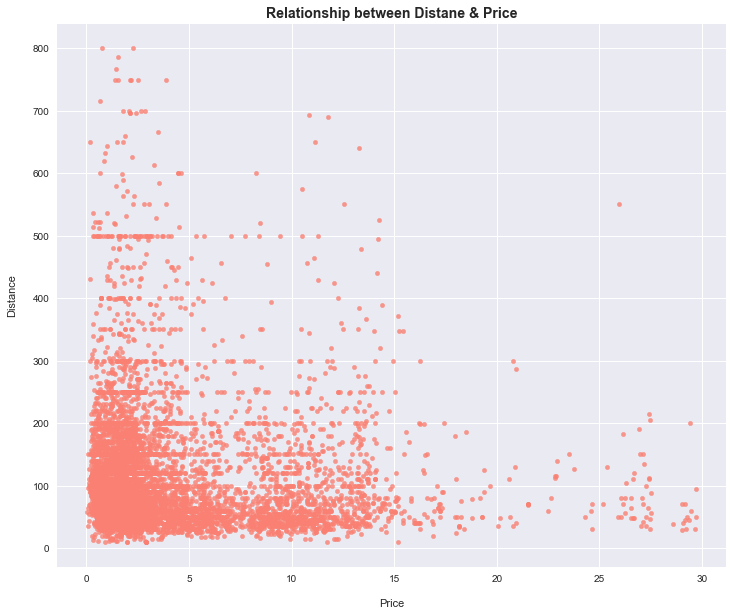

In [45]:
fig = plt.figure(figsize = (12, 10))
plt.scatter(x=dataset["distance"], y=dataset["price"],  c=['#fa8072'],s=20,alpha=0.8)

plt.title('Relationship between Distane & Price', fontsize=14, fontweight='bold')
plt.xlabel('\nPrice')
plt.ylabel('Distance\n')
plt.show()

Same idea but using a diffrent tool - Seborn's jointplot 

Text(0.5, 1.0, 'Relation between Distance & Price')

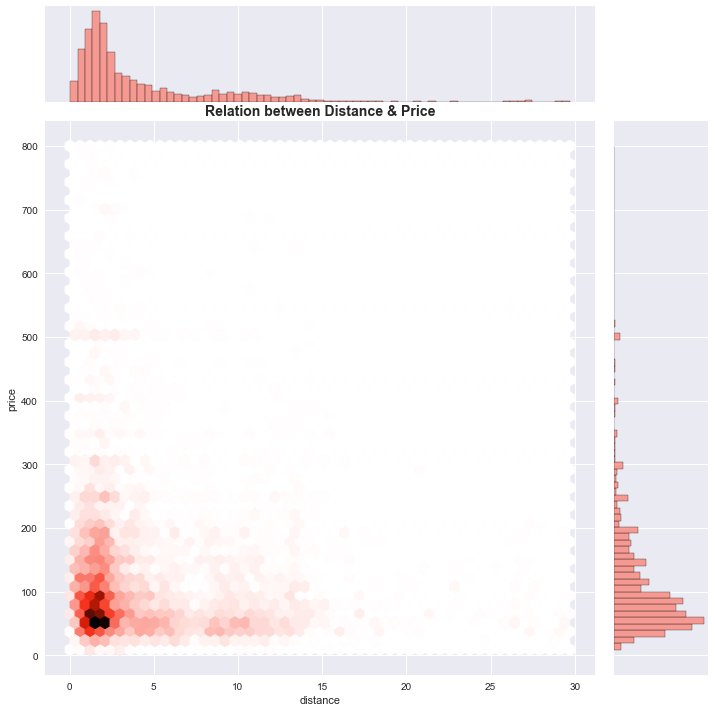

In [46]:
sns.jointplot(x=dataset["distance"], y=dataset["price"], kind="hex", color='#fa8072', height = 10)
plt.title('Relation between Distance & Price', fontsize=14, fontweight='bold')

#### Checking neighborhoods

In [47]:
print( dataset['neighbourhood_cleansed'].head(2), '\n')
print('Number of places where we have NULL values', dataset['neighbourhood_cleansed'].isnull().sum(), '\n')
print( dataset["neighbourhood_cleansed"].value_counts().sort_index(), '\n' )

id
44077    Dn Laoghaire-Rathdown
85148             South Dublin
Name: neighbourhood_cleansed, dtype: object 

Number of places where we have NULL values 0 

Dn Laoghaire-Rathdown     694
Dublin City              4934
Fingal                    563
South Dublin              242
Name: neighbourhood_cleansed, dtype: int64 



Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


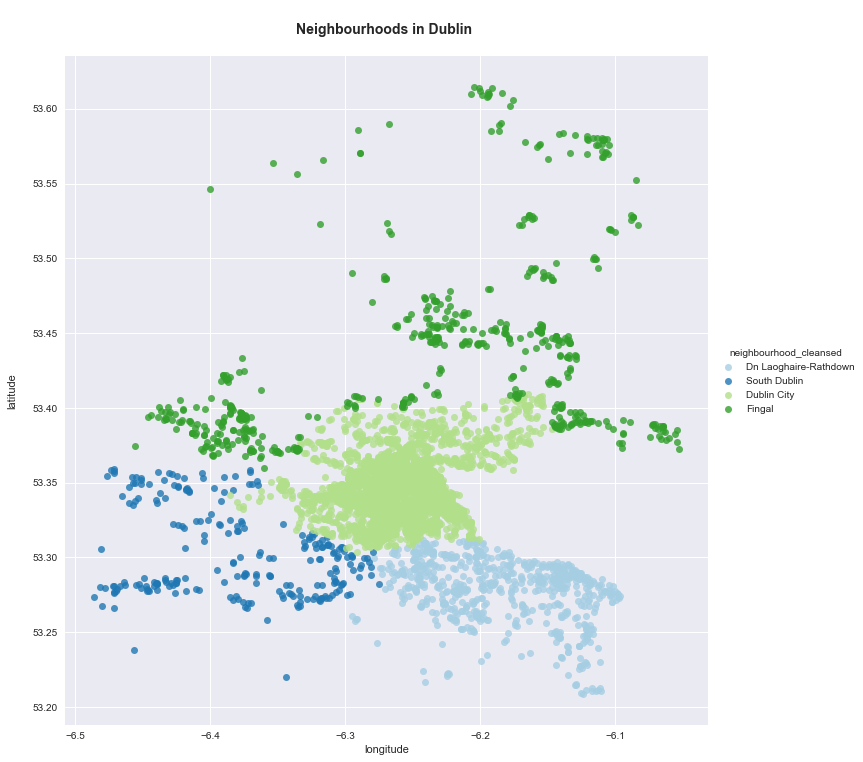

In [48]:
sns.lmplot('longitude', 'latitude', data=dataset,  hue='neighbourhood_cleansed', fit_reg=False, height=10,palette="Paired",)

plt.xlabel('longitude')
plt.ylabel('latitude\n')
plt.title('\nNeighbourhoods in Dublin \n', fontsize=14, fontweight='bold')
plt.show()

Text(0.5, 1.0, '\nMedian Prices by Neighbourhood\n')

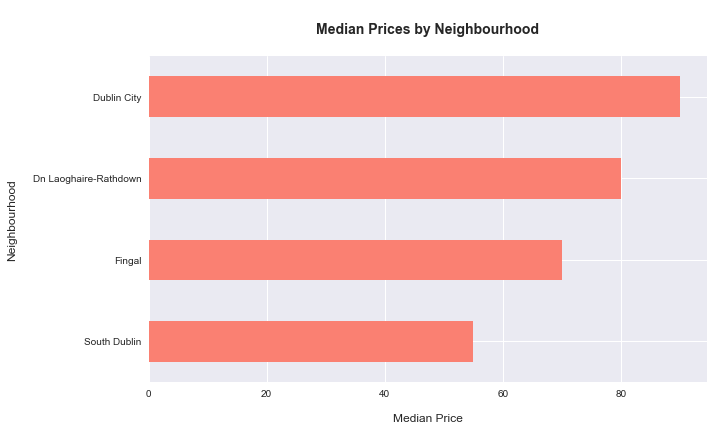

In [49]:
# group_by neighbourhood groups, take the median price and store new values in sub_df 
df_grouped = pd.DataFrame(dataset.groupby(dataset['neighbourhood_cleansed'])['price'].agg(np.median))
df_grouped.reset_index(inplace=True)


df_grouped_distane = pd.DataFrame(dataset.groupby(dataset["neighbourhood_cleansed"])["distance"].agg(np.mean))
df_grouped_distane.reset_index(inplace=True)

# plot this 
df_grouped.sort_values(by=['price'], ascending=True)\
          .plot(kind='barh', x='neighbourhood_cleansed', y='price', 
                figsize=(10,6), legend=False, color='salmon')

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('Neighbourhood\n', fontsize=12)
plt.title('\nMedian Prices by Neighbourhood\n', fontsize=14, fontweight='bold')

In [50]:
# creating the standarized pelette for presenting neighbourhoods on the map

neighbourhoods = list(dataset['neighbourhood_cleansed'].unique())
palette= list(sns.color_palette("Paired", len(neighbourhoods)))

colors = dict(zip(neighbourhoods, palette))

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


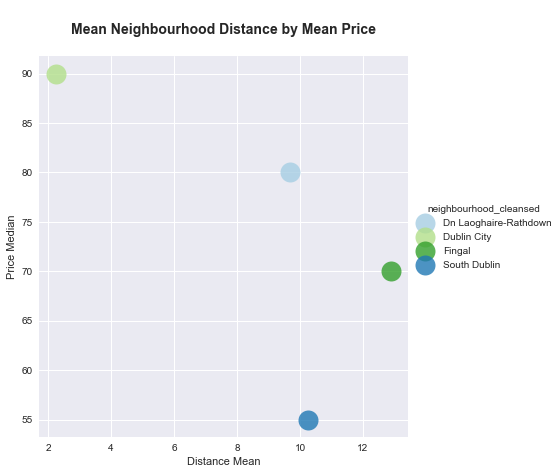

In [51]:
df_grouped_distane.sort_values(by=['neighbourhood_cleansed'])
df_grouped.sort_values(by=['neighbourhood_cleansed'])

joined = pd.merge(df_grouped_distane, df_grouped, on="neighbourhood_cleansed")


sns.lmplot('distance', 'price', data=joined,  hue='neighbourhood_cleansed', scatter_kws={"s": 400}, fit_reg=False, height=6, palette=colors)
fig.suptitle('test title')
plt.xlabel('Distance Mean')
plt.ylabel('Price Median')
plt.title('\nMean Neighbourhood Distance by Mean Price\n', fontsize=14, fontweight='bold')
plt.show()

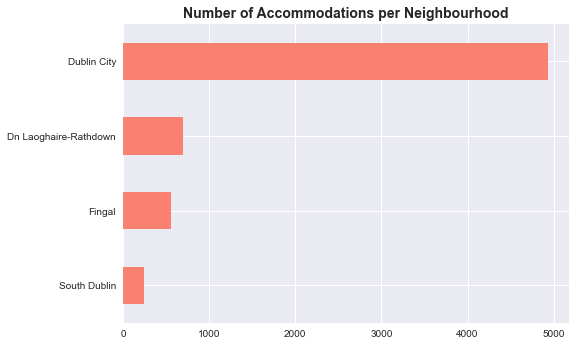

In [52]:
dataset['neighbourhood_cleansed'].value_counts().sort_values().plot(kind='barh', color='salmon')
plt.title('Number of Accommodations per Neighbourhood', fontsize=14, fontweight='bold');

### Bathrooms


In [53]:
print( dataset['bathrooms_text'].head(2), '\n')
print('Number of places where we have NULL values', dataset['bathrooms_text'].isnull().sum(), '\n')
print( dataset["bathrooms_text"].value_counts().sort_index(), '\n' )

id
44077    1.5 shared baths
85148                 NaN
Name: bathrooms_text, dtype: object 

Number of places where we have NULL values 5 

0 baths                17
0 shared baths         11
1 bath               2212
1 private bath        952
1 shared bath        1211
1.5 baths             390
1.5 shared baths      260
2 baths               761
2 shared baths        113
2.5 baths             218
2.5 shared baths       27
3 baths               115
3 shared baths         10
3.5 baths              46
3.5 shared baths        2
4 baths                33
4 shared baths          3
4.5 baths              10
5 baths                 4
5.5 baths               2
6 baths                 2
6.5 baths               1
7.5 baths               1
Half-bath               4
Private half-bath      18
Shared half-bath        5
Name: bathrooms_text, dtype: int64 



Removing null values

In [54]:
dataset.replace({'bathrooms_text' : {'0 shared baths' : '1 shared', 'Private half-bath' : '1 Private half-bath', 'Shared half-bath':'1 Shared half-bath','Half-bath':'1 Half-bath'}}, inplace=True)
print( dataset['bathrooms_text'].head(2) )

id
44077    1.5 shared baths
85148                 NaN
Name: bathrooms_text, dtype: object


In [55]:
dataset = dataset[pd.notnull(dataset['bathrooms_text'])]

Creating a new column - **bathrooms_shared**  and replacing **bathrooms_text** with **bathrooms**

In [56]:
one_bool = dataset['bathrooms_text'].str.contains('shared')
dataset.loc[one_bool,"bathrooms_shared"] = 't'
dataset['bathrooms_shared'].fillna('f', inplace=True)
dataset.replace({'bathrooms_shared' : {'t' : True, 'f' : False}}, inplace=True)


In [57]:
df = pd.DataFrame.from_dict({
   'Name': ['May21', 'James', 'Adi22', 'Hello', 'Girl90'],
   'Volume': [23, 12, 11, 34, 56],
   'Value': [21321, 12311, 4435, 32454, 654654]
})

df['Name'] = df['Name'].str.replace('\d+', '')

print(df)

    Name  Volume   Value
0    May      23   21321
1  James      12   12311
2    Adi      11    4435
3  Hello      34   32454
4   Girl      56  654654


The default value of regex will change from True to False in a future version.


In [58]:
import re

def remove_chars(s):
    return re.sub('[^\d\.]+', '', s)
dataset['bathrooms_text'] = dataset['bathrooms_text'].apply(remove_chars)

In [59]:
print( dataset['bathrooms_text'].head(2), '\n')
print('Number of places where we have NULL values', dataset['bathrooms_text'].isnull().sum(), '\n')
print( dataset["bathrooms_text"].value_counts().sort_index(), '\n' )

id
44077    1.5
85156    1.5
Name: bathrooms_text, dtype: object 

Number of places where we have NULL values 0 

0        17
1      4413
1.5     650
2       874
2.5     245
3       125
3.5      48
4        36
4.5      10
5         4
5.5       2
6         2
6.5       1
7.5       1
Name: bathrooms_text, dtype: int64 



In [60]:
dataset['bathrooms'] = dataset['bathrooms_text'].astype('float64')

In [61]:
dataset["bathrooms"].describe()

count   6428.00
mean       1.33
std        0.61
min        0.00
25%        1.00
50%        1.00
75%        1.50
max        7.50
Name: bathrooms, dtype: float64

### Room type

In [62]:
print( dataset['room_type'].head(2), '\n')
print('Number of places where we have NULL values', dataset['room_type'].isnull().sum(), '\n')
print( dataset["room_type"].value_counts().sort_index(), '\n' )

id
44077    Private room
85156    Private room
Name: room_type, dtype: object 

Number of places where we have NULL values 0 

Entire home/apt    3089
Hotel room           48
Private room       3158
Shared room         133
Name: room_type, dtype: int64 



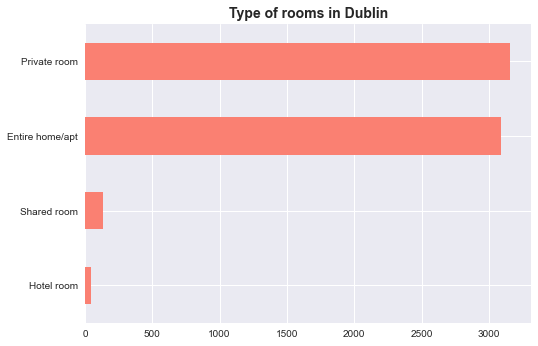

In [63]:
dataset['room_type'].value_counts().sort_values().plot(kind='barh', color='salmon')
plt.title('Type of rooms in Dublin', fontsize=14, fontweight='bold');

**Dummy Coding of room_type**

In [64]:
dataset = pd.get_dummies(dataset, columns=['room_type'])

In [65]:
dataset.columns

Index(['host_is_superhost', 'host_identity_verified', 'neighbourhood_cleansed',
       'latitude', 'longitude', 'accommodates', 'bathrooms_text', 'bedrooms',
       'beds', 'price', 'instant_bookable', 'amenities_no', 'distance',
       'bathrooms_shared', 'bathrooms', 'room_type_Entire home/apt',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room'],
      dtype='object')

In [66]:
dataset.rename(columns={
    'room_type_Entire home/apt': 'entire_home_apt',
    'room_type_Hotel room': 'hotel_room',
    'room_type_Private room': 'private_room',
    'room_type_Shared room': 'shared_room'
                               }, inplace=True)

In [67]:
dataset.drop(['bathrooms_text','latitude', 'longitude','neighbourhood_cleansed'], axis=1, inplace=True)
dataset.columns

Index(['host_is_superhost', 'host_identity_verified', 'accommodates',
       'bedrooms', 'beds', 'price', 'instant_bookable', 'amenities_no',
       'distance', 'bathrooms_shared', 'bathrooms', 'entire_home_apt',
       'hotel_room', 'private_room', 'shared_room'],
      dtype='object')

# Finding features that are most impacting the prices of Airbnbs using Linear Regresion & LASSO
#
# DUBLIN

## Linear regression


In [68]:
['host_is_superhost', 'host_identity_verified', 'accommodates',
       'bedrooms', 'beds', 'price', 'instant_bookable', 'amenities_no',
       'distance', 'bathrooms_shared', 'bathrooms', 'entire_home_apt',
       'hotel_room', 'private_room', 'shared_room']


['host_is_superhost',
 'host_identity_verified',
 'accommodates',
 'bedrooms',
 'beds',
 'price',
 'instant_bookable',
 'amenities_no',
 'distance',
 'bathrooms_shared',
 'bathrooms',
 'entire_home_apt',
 'hotel_room',
 'private_room',
 'shared_room']

### 1st Run

In [69]:
model = smf.ols('price ~ bedrooms + beds + bathrooms + accommodates ', data=dataset).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:                     1104.
Date:                Wed, 08 Dec 2021   Prob (F-statistic):               0.00
Time:                        10:57:49   Log-Likelihood:                -36980.
No. Observations:                6428   AIC:                         7.397e+04
Df Residuals:                    6423   BIC:                         7.400e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       11.9945      2.339      5.128   

### 2nd Run

In [70]:
model = smf.ols('price ~ host_is_superhost + host_identity_verified + accommodates + bedrooms + beds + price + instant_bookable + amenities_no + distance + bathrooms_shared + bathrooms + entire_home_apt + hotel_room + private_room + shared_room', data=dataset).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.892e+32
Date:                Wed, 08 Dec 2021   Prob (F-statistic):               0.00
Time:                        10:57:49   Log-Likelihood:             1.8051e+05
No. Observations:                6428   AIC:                        -3.610e+05
Df Residuals:                    6413   BIC:                        -3.609e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

### 3rd Run

In [71]:
model = smf.ols('price ~ host_is_superhost + host_identity_verified  + accommodates + bedrooms + beds + price + distance + bathrooms_shared + bathrooms + entire_home_apt + private_room + shared_room', data=dataset).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.771e+32
Date:                Wed, 08 Dec 2021   Prob (F-statistic):               0.00
Time:                        10:57:49   Log-Likelihood:             1.8223e+05
No. Observations:                6428   AIC:                        -3.644e+05
Df Residuals:                    6415   BIC:                        -3.644e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

### 4th Run

In [72]:
model = smf.ols('price ~ host_is_superhost + host_identity_verified + accommodates + bedrooms + price + distance + bathrooms_shared + bathrooms + private_room + shared_room', data=dataset).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.605e+32
Date:                Wed, 08 Dec 2021   Prob (F-statistic):               0.00
Time:                        10:57:49   Log-Likelihood:             1.8390e+05
No. Observations:                6428   AIC:                        -3.678e+05
Df Residuals:                    6417   BIC:                        -3.677e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

### 5th Run

In [73]:
model = smf.ols('price ~ host_is_superhost + host_identity_verified + accommodates + bedrooms + price + distance + bathrooms + private_room', data=dataset).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.363e+33
Date:                Wed, 08 Dec 2021   Prob (F-statistic):               0.00
Time:                        10:57:49   Log-Likelihood:             1.8506e+05
No. Observations:                6428   AIC:                        -3.701e+05
Df Residuals:                    6419   BIC:                        -3.700e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

### 6th Run

In [74]:
model = smf.ols('price ~ host_is_superhost + host_identity_verified + accommodates + price + distance + bathrooms + private_room', data=dataset).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.088e+33
Date:                Wed, 08 Dec 2021   Prob (F-statistic):               0.00
Time:                        10:57:49   Log-Likelihood:             1.8600e+05
No. Observations:                6428   AIC:                        -3.720e+05
Df Residuals:                    6420   BIC:                        -3.719e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

# Lasso 

(0.001904052196492772,
 102.52076658893864,
 -13.507629928059437,
 42.33264207095017)

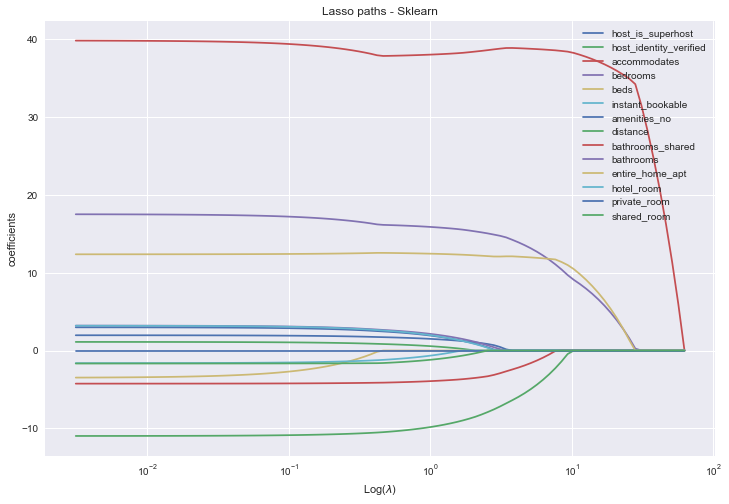

In [91]:
variables = ['host_is_superhost', 'host_identity_verified', 'accommodates','bedrooms', 'beds', 
             'instant_bookable', 'amenities_no', 'distance', 'bathrooms_shared', 'bathrooms', 
             'entire_home_apt','hotel_room', 'private_room', 'shared_room']


data_subset = dataset.loc[:, variables + ['price']]

X = data_subset.loc[:,variables]
X = preprocessing.scale(X)
y = np.array(data_subset.price)

alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps = 5e-5)

# Display results
plt.figure(figsize = (12,8))

for i in range(X.shape[1]):
    plt.plot(alphas_lasso, coefs_lasso[i], label = variables[i])

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('coefficients')
plt.title('Lasso paths - Sklearn')
plt.legend()
plt.axis('tight')

## xgboost

In [93]:
# import train_test_split function
from sklearn.model_selection import train_test_split
# import metrics
from sklearn.metrics import mean_squared_error, r2_score


variables = ['host_is_superhost', 'host_identity_verified', 'accommodates','bedrooms', 'beds', 
             'instant_bookable', 'amenities_no', 'distance', 'bathrooms_shared', 'bathrooms', 
             'entire_home_apt','hotel_room', 'private_room', 'shared_room']


data_subset = dataset.loc[:, variables + ['price']]


# split our data
X_train, X_test, y_train, y_test = train_test_split(dataset[variables], dataset['price'], test_size=0.2)


In [95]:
# scale data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

In [96]:
import xgboost as xgb

# create a baseline
booster = xgb.XGBRegressor()

In [97]:
from sklearn.model_selection import GridSearchCV
# create Grid
param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth': [3, 4, 5, 6, 7],
              'colsample_bytree': [0.6, 0.7, 1],
              'gamma': [0.0, 0.1, 0.2]}

# instantiate the tuned random forest
booster_grid_search = GridSearchCV(booster, param_grid, cv=3, n_jobs=-1)

# train the tuned random forest
booster_grid_search.fit(X_train, y_train)

# print best estimator parameters found during the grid search
print(booster_grid_search.best_params_)

# OUTPUT DUBLIN
#   {'colsample_bytree': 0.7, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

{'colsample_bytree': 0.7, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


In [101]:
# instantiate xgboost with best parameters
booster = xgb.XGBRegressor(colsample_bytree=0.7, gamma=0.0, learning_rate=0.1, 
                           max_depth=3, n_estimators=100)

# train
booster.fit(X_train, y_train)

# predict
y_pred_train = booster.predict(X_train)
y_pred_test = booster.predict(X_test)

In [102]:
RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE: {round(RMSE, 4)}")

RMSE: 70.3112


In [103]:
r2 = r2_score(y_test, y_pred_test)
r2
print(f"r2: {round(r2, 4)}")

r2: 0.483


In [104]:
xg_train = xgb.DMatrix(data=X_train, label=y_train)

In [105]:
params = {'colsample_bytree':0.7, 'gamma':0.0, 'learning_rate':0.1, 'max_depth':3}

cv_results = xgb.cv(dtrain=xg_train, params=params, nfold=3,
                    num_boost_round=200, early_stopping_rounds=10, 
                    metrics="rmse", as_pandas=True)

In [106]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,141.51,0.70,141.54,1.39
1,131.71,0.69,131.83,1.63
2,123.17,0.81,123.29,1.71
3,115.69,0.89,115.89,1.79
4,109.22,0.91,109.41,1.90


Text(0.5, 0, 'Relative Feature Importance with XGBoost')

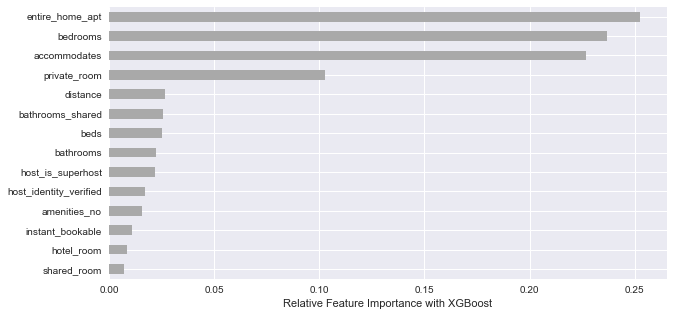

In [107]:
# plot the important features
feat_importances = pd.Series(booster.feature_importances_, index=variables)
feat_importances.nlargest(15).sort_values().plot(kind='barh', color='darkgrey', figsize=(10,5))
plt.xlabel('Relative Feature Importance with XGBoost')